In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.colors import LinearSegmentedColormap
import os

In [54]:
# choose basa or GG
database = 'basa' # 'basa' or 'GG'

if database == 'basa':
    results = 'results_basa'
    data_species = 'GAM_species/species_fit_140_0.01.pkl'
    windows = [(0, 40), (20, 60), (40, 80), (60, 100), (80, 120), (100, 140)]
    windows = [(0, 50), (51, 84), (85, 140)]
    
if database == 'GG':
    results = 'results_GG'
    data_species = '../data_GG/GAM/species_fit_301_0.01.pkl'
    windows = [(0, 100), (50, 150), (100, 200), (150, 250), (200, 300)]
    windows = [(150, 199), (200, 249)]
    windows = [(0, 56), (57, 149), (150, 249), (250, 300)]



species_index = pd.read_pickle(f'{results}/species_index.pkl')
species_index_T = pd.Series(species_index)
species_index_T = pd.Series(species_index_T.index, index = species_index_T.values)
species_index_T = species_index_T.to_dict()

if database == 'basa':
    species_index_non_aq = {k: v for k, v in species_index.items()}
    species_index_T_non_aq = {v: k for k, v in species_index_non_aq.items()}
    non_aq_species = list(species_index_non_aq.keys())
if database == 'GG':
    # ONLY NON AQUATIC SPECIES
    non_aq_species = 'Alchemilla,Chenopodiaceae,Artemisia,Cichoroideae,Asteroideae,Carduus,Asteraceae,Vernonia,Polygonum,Tribulus,Galium,Brassicaceae,Caryophylaceae,Swertia,Senecio,Erica,Hypericum,Anthospermum,Cerastium,Apiaceae,Podocarpus,Euclea,Hagenia,Juniperus,Myrsine,Rapanea,Rosa,Schefflera,Brucea,Sapotaceae,Iridaceae,Anthyllis,Maytenus,Buxus,Psydrax,Celastraceae,Celtis,Dodonaea,Ekebergia,Ephedra,Clematis,Myrica,Hypoestes,Ziziphus,Acanthus,Allophylus,Acacia,Combretum,Commiphora,Cussonia,Dobera,Lannea,Macaranga,Olea,Jasminum,Rhus,Securinega,Teclea,Zanthoxylum,Cassia,Capparidaceae,Acalypha,Euphorbia,Euphorbiacea,Phyllantus,Tamarindus,Alchornea,Aloe,Asphodellus,Leguminosae,Rubiaceae,Blepharis,Justicia,Heliotropium,Kohautia,Indigofera,Lamiaceae,Cerealia,Plantago,Planceolata,Poaceae,Rumex,Solanum,Urticaceae,Ricinus,Saussurea'.replace(' ','_').split(',')

    # species_index_non_aq = species_index
    # species_index_T_non_aq = species_index_T
    species_index_non_aq = {k: v for k, v in species_index.items() if k in set(non_aq_species)}
    species_index_T_non_aq = {v: k for k, v in species_index_non_aq.items()}



abundances = pd.read_pickle(data_species)
for species in abundances.columns:                  # 0.001 if percentages
    abundances[species]['y'][abundances[species]['y'] < 1] = 0

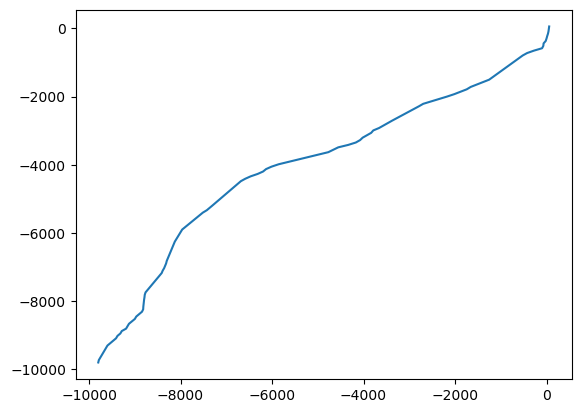

In [91]:
plt.plot(abundances['Abies']['prev_x'], abundances['Abies']['x'])

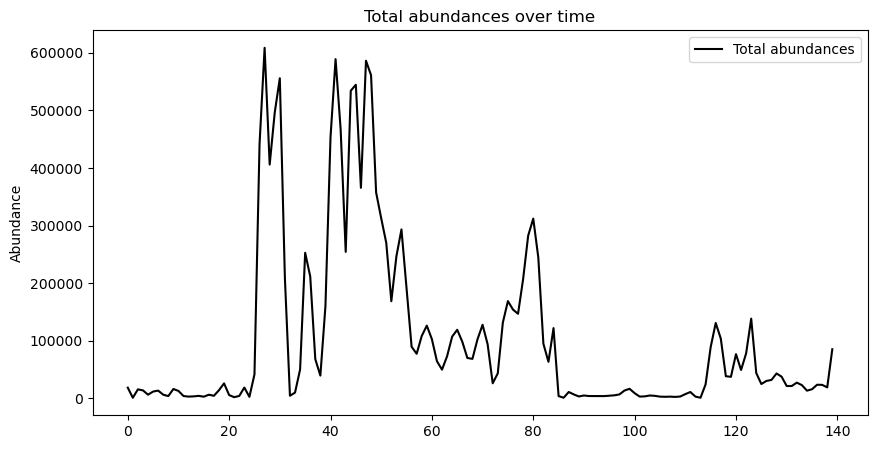

In [56]:
# plot the total abundances over time
abundances_sum = pd.DataFrame({k: v['y'] for k, v in abundances.items() if k in species_index_non_aq.keys()})
abundances_sum = abundances_sum.values.sum(axis=1)
plt.figure(figsize=(10, 5))
plt.plot(abundances_sum, label='Total abundances', color='black')
# plt.xlabel('Time')
plt.ylabel('Abundance')
plt.title('Total abundances over time')
plt.legend()

In [57]:
# read granger causalities

causality_name = 'granger_causalities' # 'granger_causalities' or 'conditional_GC'
causality_name = 'conditional_GC' # 'granger_causalities' or 'conditional_GC'

granger_causalities = []
granger_causalities_p_values = []
for idx,(start,end) in enumerate(windows):
    granger_causality = pd.read_pickle(f'{results}/{causality_name}/original_table_{start}:{end}.pkl')
    granger_causality[granger_causality > 100] = 0
    granger_causality[granger_causality < -100] = 0
    # granger_causality[np.eye(granger_causality.shape[0], dtype=bool)] = np.nan
    granger_causalities.append(granger_causality)

    granger_causality_p_values = pd.read_pickle(f'{results}/{causality_name}/original_table_p_values_{start}:{end}.pkl')
    granger_causality_p_values[np.eye(granger_causality_p_values.shape[0], dtype=bool)] = np.nan
    granger_causalities_p_values.append(granger_causality_p_values)

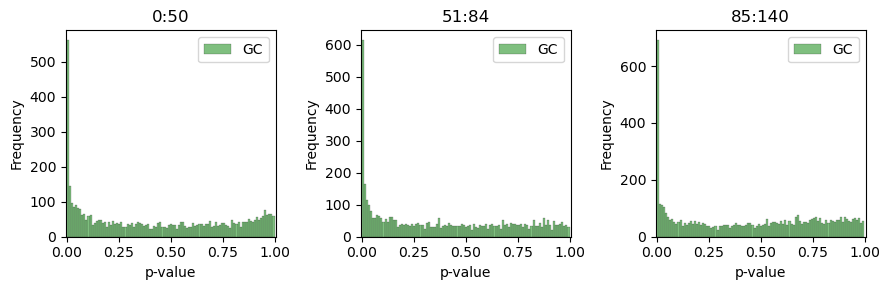

In [58]:
fig,axes = plt.subplots(1,len(windows),figsize=(3*len(windows), 3))
for idx in range(len(windows)):

    # every link that has a p-value of 1 in GC, put a p-value of 1 also in TE
    granger_causalities_p_values[idx][granger_causalities_p_values[idx] == 1.0] = np.nan
    # p_values_list[idx][granger_causalities_p_values[idx] == 1.0] = np.nan

    ax = axes.flatten()[idx]
    # ax.hist(p_values_list[idx].flatten(), bins = int(51), alpha=0.5, edgecolor='black', linewidth=0.25, color='blue', label='TE')
    granger_causality_pvalues = granger_causalities_p_values[idx].flatten()
    ax.hist(granger_causality_pvalues, bins = int(101), alpha=0.5, edgecolor='black', linewidth=0.25, color='green', label='GC')
    ax.set_xlabel('p-value')
    ax.set_ylabel('Frequency')
    ax.legend()
    (start, end) = windows[idx]
    ax.set_title(f'{start}:{end}')
    ax.set_xlim(-0.005,1.005)
fig.set_tight_layout(True)
# fig.savefig(f'./{results}/TE_vs_GC_p_values.png', dpi=300)

In [59]:
import networkx as nx



# grab the top L edges
# L = 100
graphs = []

for idx,(start,end) in enumerate(windows):
    
    # for the TE p_values (p_values_list) or the gc p_values (granger_causalities_p_values)
    # adjacency = p_values_list[idx]
    adjacency = granger_causalities_p_values[idx]
    # remove na from the numpy array adjacency
    adjacency = np.nan_to_num(adjacency, nan=1.0)
    # ONLY NON AQUATIC SPECIES
    species_list = list(species_index_T_non_aq.keys())

    # adjacency_non_aq = adjacency[np.ix_(species_list, species_list)]
    # cut_value = np.sort(adjacency_non_aq.flatten())[L]

    cut_value = 0.01

    adjacency_pvalued = (adjacency <= cut_value).astype(int)
    adjacency = granger_causalities[idx] * adjacency_pvalued
    
    graph = nx.from_numpy_array(adjacency, create_using=nx.DiGraph, edge_attr='weight')
    # remove all nodes that are not in the non_aq_species list
    graph.remove_nodes_from([node for node in graph.nodes() if species_index_T[node] not in non_aq_species])
    graphs.append(graph)
    print(cut_value, graph.number_of_edges())

# explanation cause it's confusing
# we need to create the graph with the indices of the original species index, so we use the whole adjacency matrix
# however to remove the aquatic nodes and keep 100 links, we count them on the adjacency_non_aq, then create the whole graph, then remove again the aquatic nodes
# this should leave about the 100 links

0.01 559
0.01 605
0.01 689


In [95]:
# find out which species have the lowest p value
p_values = granger_causalities_p_values[0] # a numpy matrix of the pairs of species and the p-value of their granger causality

# find the pair with the lowest p-value
# create a dataframe with all the pairs of species and their p-values
rows = []
for i in range(p_values.shape[0]):
    for j in range(p_values.shape[1]):
        if not np.isnan(p_values[i, j]):
            row = {'species_1': species_index_T[i], 'species_2': species_index_T[j], 'p_value': p_values[i, j]}
            rows.append(row)

p_values_df = pd.DataFrame(rows)
p_values_df = p_values_df.sort_values(by='p_value', ascending=True)
p_values_df

species_1          species_2       p_value
1679  Ephedra fragilis  Ephedra distachya  1.418570e-26
229              Taxus  Ephedra distachya  1.983917e-26
4715     Valerianaceae  Ephedra distachya  1.400745e-24
2617         Centaurea          Cistaceae  3.038944e-24
3891       Primulaceae    Ilex aquifolium  2.529746e-17
...                ...                ...           ...
2452          Cardueae     Chenopodiaceae  9.984019e-01
788           Fraxinus             Myrtus  9.987642e-01
2503         Rubiaceae           Sambucus  9.993241e-01
1216           Rhamnus            Genista  9.995727e-01
3832     Euphorbiaceae          Centaurea  9.999537e-01

[4830 rows x 3 columns]

Ephedra fragilis Ephedra distachya


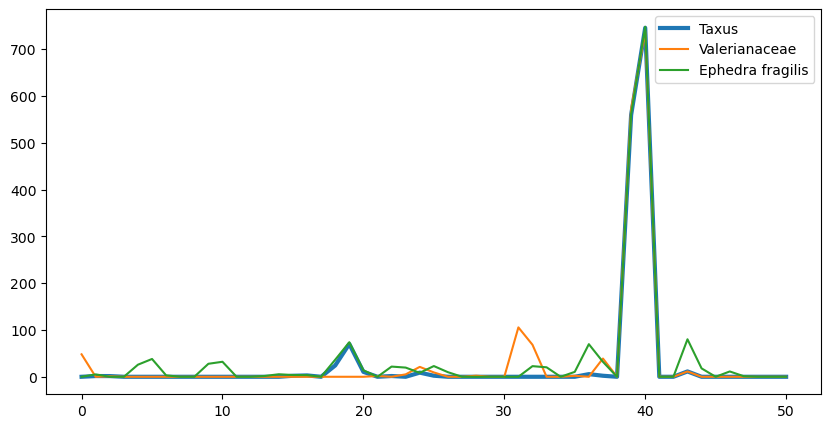

In [128]:
# draw the abundances of Galium and Fagus
fig, ax = plt.subplots(figsize=(10, 5))
idx = 0
species1, species2 = p_values_df.iloc[idx][['species_1', 'species_2']]
print(species1, species2)
# ax.plot(abundances[species1]['prev_y'][0:], label=species1, color='blue')
# ax.plot(abundances[species2]['prev_y'][0:], label=species2, color='red')

ax.plot(           abundances['Taxus']['y'][0:51], label='Taxus', lw=3)
ax.plot(   abundances['Valerianaceae']['y'][0:51], label='Valerianaceae')
ax.plot(abundances['Ephedra fragilis']['y'][0:51], label='Ephedra fragilis')


ax.legend()

## Degree distribution

In [71]:
for idx in range(len(windows)):
    out_degree_1 = np.array([graphs[idx].out_degree(n) for n in graphs[idx].nodes() if (abundances[species_index_T_non_aq[n]]['y'][windows[idx][0]:windows[idx][1]].sum() > 0)])
    out_degree_2 = np.array([graphs[idx].out_degree(n) for n in graphs[idx].nodes()])
    print(len(out_degree_2) - len(out_degree_1), ", ", len(out_degree_2))

9 ,  79
9 ,  79
2 ,  79


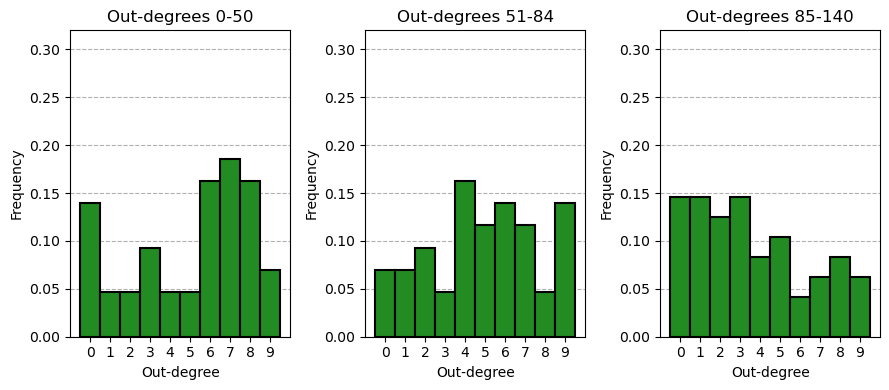

In [72]:
# calculate out-degree distributions

fig, axes = plt.subplots(1, len(windows), figsize=(3*len(windows), 4))
degree_distributions = []
for idx, graph in enumerate(graphs):
    # Only take into account nodes with abundance higher than 0

    out_degree = np.array([graphs[idx].out_degree(n) for n in graphs[idx].nodes() if (abundances[species_index_T_non_aq[n]]['y'][windows[idx][0]:windows[idx][1]].sum() > 0)])
    degree_distributions.append(out_degree)
    # plot the degree distributions
    ax = axes.flatten()[idx]
    ax.grid(axis='y', zorder=0, linestyle='--', alpha=1)
    ax.hist(out_degree, histtype='bar',
            bins=np.arange(-0.5, 10.5, 1),
            # bins=np.arange(-0.5, out_degree.max()+0.5, 1),
            density=True, zorder=3,
            edgecolor='black', linewidth=1.5, color = 'forestgreen')
    ax.set_xlabel('Out-degree')
    ax.set_ylabel('Frequency')
    (start, end) = windows[idx]
    ax.set_title(f'Out-degrees {start}-{end}')
    ax.set_ylim(0,0.32)
    ax.set_xticks(np.arange(0, 10, 1))
    ax.set_xticklabels(np.arange(0, 10, 1), rotation=0)
fig.set_tight_layout(True)
# fig.savefig(f'./{results}/cgc_out_degree_distributions_firewindows.png', dpi=300)

In [73]:
# Percentage of positive and negative links
positive_links = []
negative_links = []
for idx, graph in enumerate(graphs):
    positive_links.append(len([e for e in graph.edges(data=True) if e[2]['weight'] > 0]) / graph.number_of_edges())
    negative_links.append(len([e for e in graph.edges(data=True) if e[2]['weight'] < 0]) / graph.number_of_edges())

In [74]:
print(np.array(positive_links)*100)
print(np.array(negative_links)*100)

[67.44186047 66.28099174 66.47314949]
[32.55813953 33.71900826 33.52685051]


## Individual temporalities of nodes

559 605
1 - Temporality [0-50] -> [51-84]: 0.073   (mean random: 0.039, std: 0.020)
605 689
1 - Temporality [51-84] -> [85-140]: 0.061   (mean random: 0.043, std: 0.023)


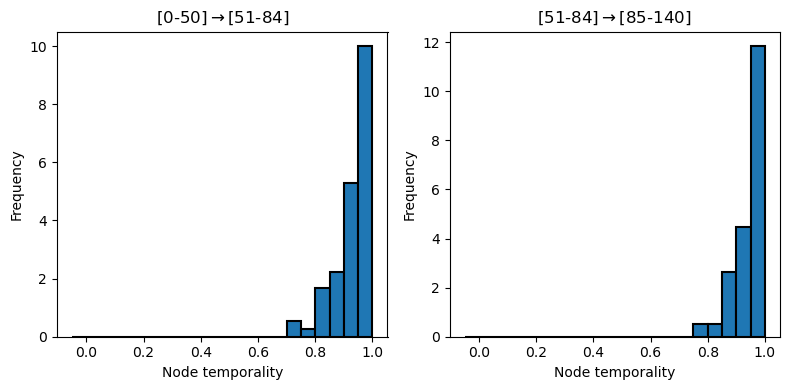

In [75]:
# individual temporalities of nodes
fig, axes = plt.subplots(1, len(windows)-1, figsize=(4*(len(windows)-1),4), layout='tight')

temporalities = pd.DataFrame(index = [species_index_T_non_aq[node] for node in graphs[idx].nodes()])
for i in range(0,len(graphs)-1):
    edg1 = set(graphs[i].edges)
    edg2 = set(graphs[i+1].edges)
    # edge temporality for each node: make a histogram of the number of edges that are present in both graphs for each node
    node_temporality = []
    for node in graphs[i].nodes():
        edg1_node = set(graphs[i].edges(node))
        edg2_node = set(graphs[i+1].edges(node))
        if len(edg1_node | edg2_node) != 0: 
            node_temporality.append(1 - len(edg1_node & edg2_node) / len(edg1_node | edg2_node))
        else:
            node_temporality.append(np.nan)

    # temporalities[i] = [node_temporality[i] for i, node in enumerate(graphs[idx].nodes())]
    
    # plot the histogram of node_temporality
    ax = axes.flatten()[i]
    ax.hist(node_temporality, bins=np.arange(-0.05, 1.05, 0.05), density=True,
            edgecolor='black', linewidth=1.5, histtype='bar', zorder=3)
    ax.set_xlabel('Node temporality')
    ax.set_ylabel('Frequency')
    ax.set_title(f'[{windows[i][0]}-{windows[i][1]}]' + r'$\rightarrow$' + f'[{windows[i+1][0]}-{windows[i+1][1]}]')

    #network temporality
    temporality = 1. - (1. - len(edg1 & edg2) / len(edg1 | edg2))

    # compare with random graphs

    random_temporalities = np.zeros(100)  # Store temporality for 100 iterations
    n = graphs[i].number_of_nodes()
    l1 = graphs[i].number_of_edges()
    l2 = graphs[i+1].number_of_edges()
    print(l1, l2)
    for t in range(len(temporalities)):
        g1 = nx.gnm_random_graph(n, l1, directed=True)
        g2 = nx.gnm_random_graph(n, l2, directed=True)
        # calculate the temporality of the random graphs
        edg1 = set(g1.edges)
        edg2 = set(g2.edges)
        random_temporality = 1. - (1. - len(edg1 & edg2) / len(edg1 | edg2))
        random_temporalities[t] = random_temporality

    print(f'1 - Temporality [{windows[i][0]}-{windows[i][1]}] -> [{windows[i+1][0]}-{windows[i+1][1]}]: {temporality:.3f}' + 
          f'   (mean random: {random_temporalities.mean():.3f}, std: {random_temporalities.std():.3f})')

# fig.savefig(f'./{results}/node_temporality_firewinkdows.png', dpi=300, bbox_inches='tight')

In [76]:
# make two random graphs with n nodes and l number of edges
n = graphs[0].number_of_nodes()
for idx in range(len(graphs)-1):
    l1 = graphs[idx].number_of_edges()
    l2 = graphs[idx+1].number_of_edges()
    temporalities = np.zeros(100)  # Store temporality for 100 iterations
    for t in range(100):
        g1 = nx.gnm_random_graph(n, l1, directed=True)
        g2 = nx.gnm_random_graph(n, l2, directed=True)
        # calculate the temporality of the random graphs
        edg1 = set(g1.edges)
        edg2 = set(g2.edges)
        temporality = 1. - (1. - len(edg1 & edg2) / len(edg1 | edg2))
        temporalities[t] = temporality
    print(f'Random graph temporality [{windows[idx][0]}-{windows[idx][1]}] -> [{windows[idx+1][0]}-{windows[idx+1][1]}]: {np.mean(temporalities):.3f} ± {np.std(temporalities):.3f}')



Random graph temporality [0-50] -> [51-84]: 0.049 ± 0.006
Random graph temporality [51-84] -> [85-140]: 0.055 ± 0.007


In [77]:
temporalities.sort_values(by=0)

AttributeError: 'numpy.ndarray' object has no attribute 'sort_values'

## Eigenvector centrality

In [78]:
from scipy.sparse.csgraph import laplacian
from scipy.linalg import eig
centralities = pd.DataFrame(index=[species_index_T_non_aq[node] for node in graphs[0].nodes()])
for idx,G in enumerate(graphs):
    centralities[idx] = nx.eigenvector_centrality(G.reverse(), max_iter=1000).values()
    # pd.Series(centralities[i].values(), index=[species_index_T_non_aq[node] for node in G.nodes()]).sort_values(ascending=False).head(20)
centralities['sum'] = centralities.sum(axis=1)

In [79]:
centralities.sort_values(by='sum', ascending=False).to_csv(f'./{results}/centralities_firewindows.csv', sep='|', index=True)

### Correlation between eigenvector centralities across windows

<Axes: >

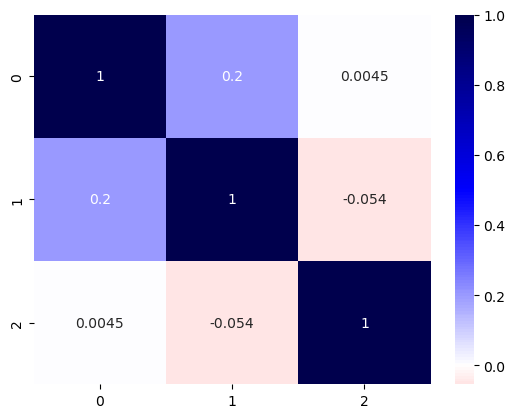

In [80]:
import seaborn as sns
corr_matrix = centralities.drop(columns=['sum']).corr(method='pearson')
sns.heatmap(corr_matrix, annot=True, cmap='seismic_r', center=0)


## Distances between graphs (windows)

In [81]:
import networkx as nx
from collections import Counter
import hashlib

def weisfeiler_lehman_kernel(g1, g2, h=2):
    def initial_labeling(graph):
        return {node: str(graph.degree[node]) for node in graph.nodes()}
    
    def aggregate_labels(graph, labels):
        new_labels = {}
        for node in graph.nodes():
            neighbor_labels = sorted(labels[neighbor] for neighbor in graph.neighbors(node))
            long_label = labels[node] + "_" + "_".join(neighbor_labels)
            # Hash the label for uniqueness
            new_labels[node] = hashlib.md5(long_label.encode()).hexdigest()
        return new_labels

    def label_histogram(graph, h):
        labels = initial_labeling(graph)
        hist = Counter(labels.values())
        
        for i in range(h):
            labels = aggregate_labels(graph, labels)
            hist.update(labels.values())
        
        return hist

    hist1 = label_histogram(g1, h)
    hist2 = label_histogram(g2, h)

    # Compute kernel value as inner product (can also use other distances)
    kernel_value = sum(hist1[label] * hist2[label] for label in set(hist1) | set(hist2))
    return kernel_value

for idx in range(len(graphs)-1):
    similarity = weisfeiler_lehman_kernel(graphs[idx], graphs[idx+1], h=3)
    print(f"{windows[idx][0]}-{windows[idx][1]} to {windows[idx+1][0]}-{windows[idx+1][1]} similarity: {similarity:.3f}")

# similarity between similar random graphs
import random
def generate_random_graph(num_nodes, num_edges):
    G = nx.gnm_random_graph(num_nodes, num_edges, directed=True)
    return G

idx = 1
num_nodes = graphs[idx].number_of_nodes()
num_edges1 = graphs[idx].number_of_edges()
num_edges2 = graphs[idx+1].number_of_edges()
random_graphs1 = [generate_random_graph(num_nodes, num_edges1) for _ in range(10)]
random_graphs2 = [generate_random_graph(num_nodes, num_edges2) for _ in range(10)]
similarities = []

for idx in range(len(random_graphs1)):
    similarity = weisfeiler_lehman_kernel(random_graphs1[idx], random_graphs2[idx], h=3)
    similarities.append(similarity)
print(f"Average similarity between random graphs: {np.mean(similarities):.3f} ± {np.std(similarities):.3f}")

0-50 to 51-84 similarity: 689.000
51-84 to 85-140 similarity: 395.000
Average similarity between random graphs: 431.200 ± 20.424


### Basa de la mora

0-50 to 51-84:   662 / 447

51-84 to 85-140: 442 / 428

### GG

0-56 to 57-149 similarity:     2269 / 604

57-149 to 150-249 similarity:  1235 / 815

150-249 to 250-300 similarity:  549 / 499


In [82]:
import graph_tool.all as gt
import matplotlib.colors as mcolors

# Function that returns a generator for sequential colormap colors
def sequential_color_generator(cmap_name='tab10'):
    cmap = plt.get_cmap(cmap_name)
    index = 0
    while True:
        yield cmap(index % cmap.N)
        index += 1
def sequential_custom_generator():
    colors_list = ['forestgreen', 'royalblue', 'crimson', 'grey']
    index = 0
    while True:
        yield mcolors.to_rgb(colors_list[index % len(colors_list)])
        index += 1

# Create a graph-tool Graph object from the networkx graph
def SFDP_layout(network):
    g = gt.Graph(directed=True)
    weight = g.new_edge_property("double")
    vlist = {}
    for node in network.nodes:
        #add vertex with the same index as in networkx (example: '32848242')
        vlist[node] = g.add_vertex()
        
    for edge in network.edges:
        e = g.add_edge(vlist[edge[0]], vlist[edge[1]])
        if network.edges[edge]['weight'] >= 0:
            weight[e] = np.sqrt(network.edges[edge]['weight'])
        else:
            weight[e] = -np.sqrt(-network.edges[edge]['weight'])
    # get the maximum and minimum weights in the network
    max_weight_norm = max(np.abs(weight.a))

    # state of graph with signed edges, refer to https://forum.skewed.de/t/assortative-structure-in-signed-networks-ppblockstate-covariates/1407/2
    s_map = g.new_edge_property("int")    # For sign (0 or 1)
    y_map = g.new_edge_property("double") # For transformed magnitude
    y2_map = g.new_edge_property("double") # For transformed magnitude (arctanh)
    for e in g.edges():
        # normalize to (-1, 1) open range
        x = (weight[e] / max_weight_norm) * (1-1e-6)
        s_map[e] = 0 if x < 0 else 1
        y_map[e] = -np.log(1-abs(x))
        y2_map[e] = np.arctanh(x)

        
    state = gt.minimize_nested_blockmodel_dl(g, 
                    state_args=dict(
                                    recs=[weight],
                                    rec_types=["real-normal"]
                                    ),
                    )
    
    
    pos_gt = gt.sfdp_layout(g, groups=state.levels[0].b, gamma=0.05)
    print(state)
    pos = {}
    groups = {}
    generated_colors = {}
    color_gen = sequential_custom_generator()

    for key, value in vlist.items():
        pos[key] = pos_gt[value]
        groups[key] = state.levels[0].b[value]
    for group in set(groups.values()):
        # next(color_gen)
        generated_colors[group] = next(color_gen) # np.random.rand(3,)
        # for i in range(2):
        #     next(color_gen)
    colors = [generated_colors[groups[node]] for node in network.nodes]
    widths = [np.abs(network.edges[edge]['weight']) for edge in network.edges]
    return pos, colors, state, widths

In [83]:

def custom_seismic():
    # Colors: red -> gray -> blue
    colors = [
        (0.0, 'red'),
        (0.49, 'red'),
        (0.5, 'gray'),
        (0.51, 'blue'),
        (1.0, 'blue')
    ]
    return LinearSegmentedColormap.from_list('custom_seismic_gray', colors)

In [84]:
# for every edge in the graph, calculate the correlation between the abundances of the two species
def get_correlation_edges(graph, abundances):
    correlations_edges = []
    for edge in graph.edges:
        species1 = species_index_T[edge[0]]
        species2 = species_index_T[edge[1]]
        abundance1 = abundances[species1]['y']
        abundance2 = abundances[species2]['y']
        correlation = np.corrcoef(abundance1, abundance2)[0, 1]
        correlations_edges.append(correlation)
    correlation_edges = np.array(correlations_edges)
    return correlation_edges

def get_edge_colors_and_widths(graph : nx.DiGraph, abundances, p_values):

    weight_edges = get_correlation_edges(graph, abundances)
    # used for coloring the edges: blue if positive correlation, red if negative
    def get_edge_color(correlation):
        if correlation > 0: return 'blue'
        else: return 'red'
    edge_colors = [get_edge_color(correlation) for correlation in weight_edges]
    edge_colors = [custom_seismic()((correlation+1)/2) for correlation in weight_edges]
    edge_widths = []
    for edge in graph.edges:
        p_value = p_values[edge[0], edge[1]]
        # edge_widths.append(1 / (p_value + 0.01)**(0.25))
        edge_widths.append()
    edge_widths = np.array(edge_widths)
    return edge_colors, edge_widths

In [85]:
# add many graphs together as one
big_graph = nx.DiGraph()
for idx, graph in enumerate(graphs):
    big_graph = nx.compose(big_graph, graph)

In [86]:
pos, colors, state, widths = SFDP_layout(big_graph)

<NestedBlockState object, with base <BlockState object with 79 blocks (5 nonempty), degree-corrected, with 1 edge covariate, for graph <Graph object, directed, with 79 vertices and 1653 edges, at 0x7f337a80aa30>, at 0x7f339044a350>, and 8 levels of sizes [(79, 5), (5, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f33a4cd3650>


<NestedBlockState object, with base <BlockState object with 70 blocks (3 nonempty), degree-corrected, with 1 edge covariate, for graph <Graph object, directed, with 70 vertices and 559 edges, at 0x7f33a4a6b6b0>, at 0x7f3379714cd0>, and 8 levels of sizes [(70, 3), (3, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f33a4c73df0>
<NestedBlockState object, with base <BlockState object with 70 blocks (5 nonempty), degree-corrected, with 1 edge covariate, for graph <Graph object, directed, with 70 vertices and 605 edges, at 0x7f337a9c6a30>, at 0x7f337939a350>, and 8 levels of sizes [(70, 5), (5, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f3381fa3f00>
<NestedBlockState object, with base <BlockState object with 77 blocks (7 nonempty), degree-corrected, with 1 edge covariate, for graph <Graph object, directed, with 77 vertices and 689 edges, at 0x7f3379707110>, at 0x7f3378d4b390>, and 8 levels of sizes [(77, 7), (7, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at

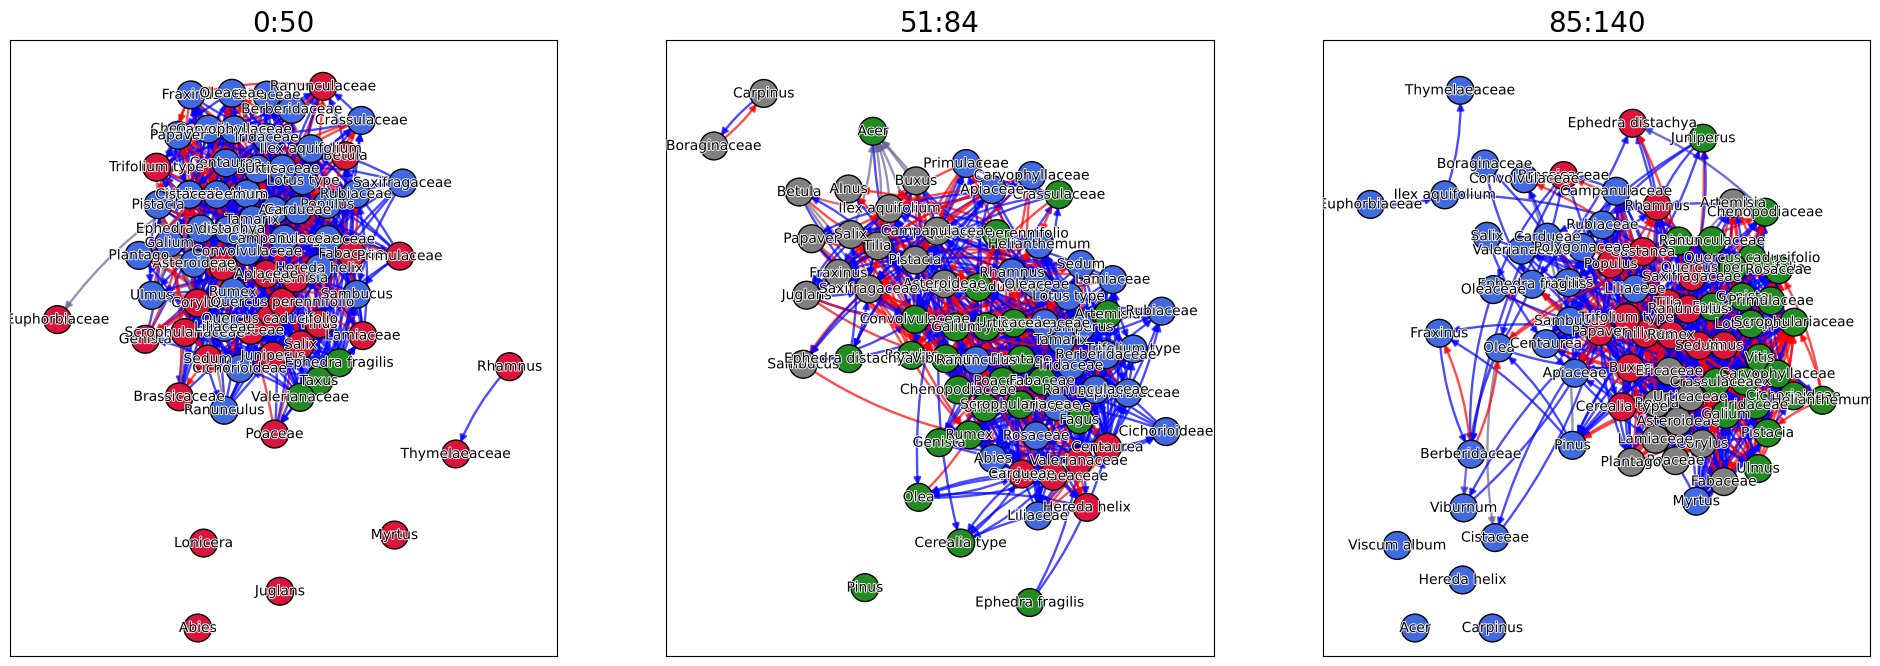

In [87]:
# select graph for visualization
fig, axes = plt.subplots(1,3, figsize=(24,8))

for idx, graph_original in enumerate(graphs):
    (start, end) = windows[idx]
    graph = graph_original.copy()
    # remove nodes that have abundance of 0 in the current window
    nodes_to_delete = []
    for node in graph.nodes():
        if abundances[species_index_T_non_aq[node]]['y'][start:end].sum() == 0:
            nodes_to_delete.append(node)
    graph.remove_nodes_from(nodes_to_delete)
    # remove the nodes from species_index_T_non_aq
    species_index_T_non_aq_abundances = {k: v for k, v in species_index_T_non_aq.items() if k not in nodes_to_delete}
    
    ax = axes.flatten()[idx]
    ax.set_title(f'{start}:{end}', fontsize=20)
    granger_causality_p_values = granger_causalities_p_values[idx]


    pos, colors, state, edge_widths = SFDP_layout(graph)

    dict_abundances = {x:abundances[x]['y'].sum() for x in abundances.columns}
    sizes = [dict_abundances[species_index_T_non_aq[x]] for x in graph.nodes]

    # edge_colors, edge_widths = get_edge_colors_and_widths(graph, abundances, granger_causality_p_values)
    edge_colors = [granger_causalities[idx][u,v] for u, v in graph.edges()]
    edge_colors = [custom_seismic()((causality+1)/2) for causality in edge_colors]


    # size of the abundances
    # nx.draw_networkx_nodes(graph, ax = ax, node_size=[np.sqrt(size)*150 for size in sizes], node_color='grey', pos=pos, edgecolors='black', linewidths=1, alpha=1)
    # constant size and color of the group
    nx.draw_networkx_nodes(graph, ax = ax, node_size=400, node_color=colors, pos=pos, edgecolors='black', linewidths=1, alpha=1)

    nx.draw_networkx_edges(graph, ax = ax, alpha = 0.7, pos=pos, width=1.7, edge_color = edge_colors, connectionstyle='arc3,rad=0.1') #edge_color=edge_colors)

    texts = nx.draw_networkx_labels(graph, ax = ax, font_size=10, labels=species_index_T_non_aq_abundances,
                            pos=pos, font_color='black', font_family='sans-serif');

    for text in texts.values():
        text.set_path_effects([path_effects.Stroke(linewidth=1.3, foreground='white'),
                        path_effects.Normal()])

# fig.savefig(f'results_basa/gc_networks/fire_windows/gc_network_{start}-{end}_positioned.pdf', dpi=300, bbox_inches='tight')

In [86]:
fig.savefig(f'{results}/conditional_gc_networks/fire_windows/conditional_gc_networks.png', dpi=200, bbox_inches='tight')


In [75]:
# save fig to pickle
import pickle
with open(f'{results}/gc_networks/fire_windows/gc_networks.pickle', 'wb') as f:
    pickle.dump(fig, f)
# save the axes to pickle
with open(f'{results}/gc_networks/fire_windows/gc_networks_axes.pickle', 'wb') as f:
    pickle.dump(axes, f)

# Matrix representation

/tmp/ipykernel_9018/487283029.py:38: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(D, method='average')
/tmp/ipykernel_9018/487283029.py:39: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_opt = optimal_leaf_ordering(Z, D)


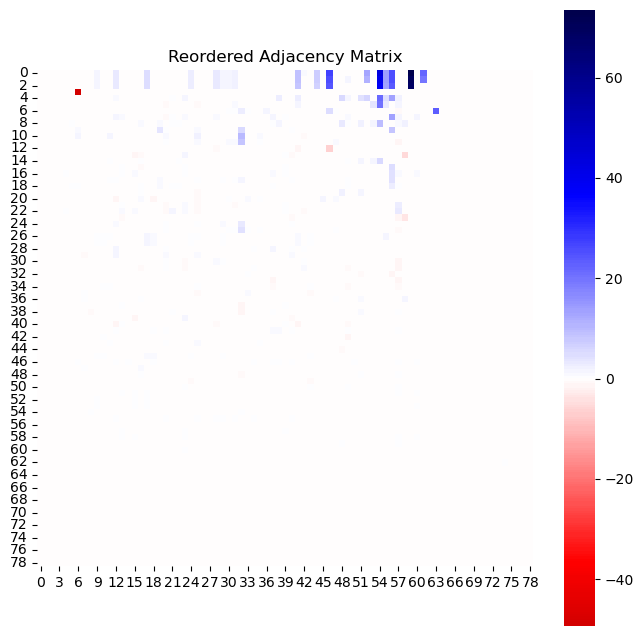

In [88]:
import networkx as nx
import numpy as np
from scipy.sparse.csgraph import laplacian
from scipy.linalg import eig

G = graphs[0]
A = nx.to_numpy_array(G)
# the original graph has the species as indices, so we create a new one
G = nx.from_numpy_array(A, create_using=nx.DiGraph)

# A = np.abs(A)

#---------------------------------------------------------------------------------
# Compute Laplacian and its eigenvectors
# L = laplacian(np.abs(A), normed=True)
# _, vecs = eig(L)
# # Get the Fiedler vector (2nd smallest eigenvalue)
# fiedler_vector = np.real(vecs[:, 1])
# # Reorder the adjacency matrix based on the Fiedler vector
# reordered_indices = np.argsort(fiedler_vector)
# reordered_A = A[reordered_indices][:, reordered_indices]
#---------------------------------------------------------------------------------
# degrees = dict(G.degree())
# # degrees with weights
# degrees = np.abs(A).sum(axis=0) + np.abs(A).sum(axis=1)
# degrees = {i: degrees[i] for i in range(len(degrees))}
# # Sort nodes by degree
# sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)
# reordered_A = A[np.ix_(sorted_nodes, sorted_nodes)]
#---------------------------------------------------------------------------------

# Seriation (Optimal Leaf Ordering)

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import optimal_leaf_ordering, linkage, leaves_list

D = squareform(pdist(A))
Z = linkage(D, method='average')
Z_opt = optimal_leaf_ordering(Z, D)
sorted_nodes = leaves_list(Z_opt)
reordered_A = A[np.ix_(sorted_nodes, sorted_nodes)]

#---------------------------------------------------------------------------------

# Reorder the adjacency matrix using the community structure (state variable)
# reordered_indices = pd.DataFrame({'i':np.arange(len(state.levels[0].b.a)), 'cluster':state.levels[0].b.a}).sort_values('cluster')['i'].values
# reordered_A = A[np.ix_(reordered_indices, reordered_indices)]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(reordered_A, cmap='seismic_r', square=True, cbar=True, center=0)


plt.title("Reordered Adjacency Matrix")
plt.show()

<NestedBlockState object, with base <BlockState object with 79 blocks (4 nonempty), degree-corrected, with 1 edge covariate, for graph <Graph object, directed, with 79 vertices and 1653 edges, at 0x7f337ade9db0>, at 0x7f33821296d0>, and 8 levels of sizes [(79, 4), (4, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f338263b950>


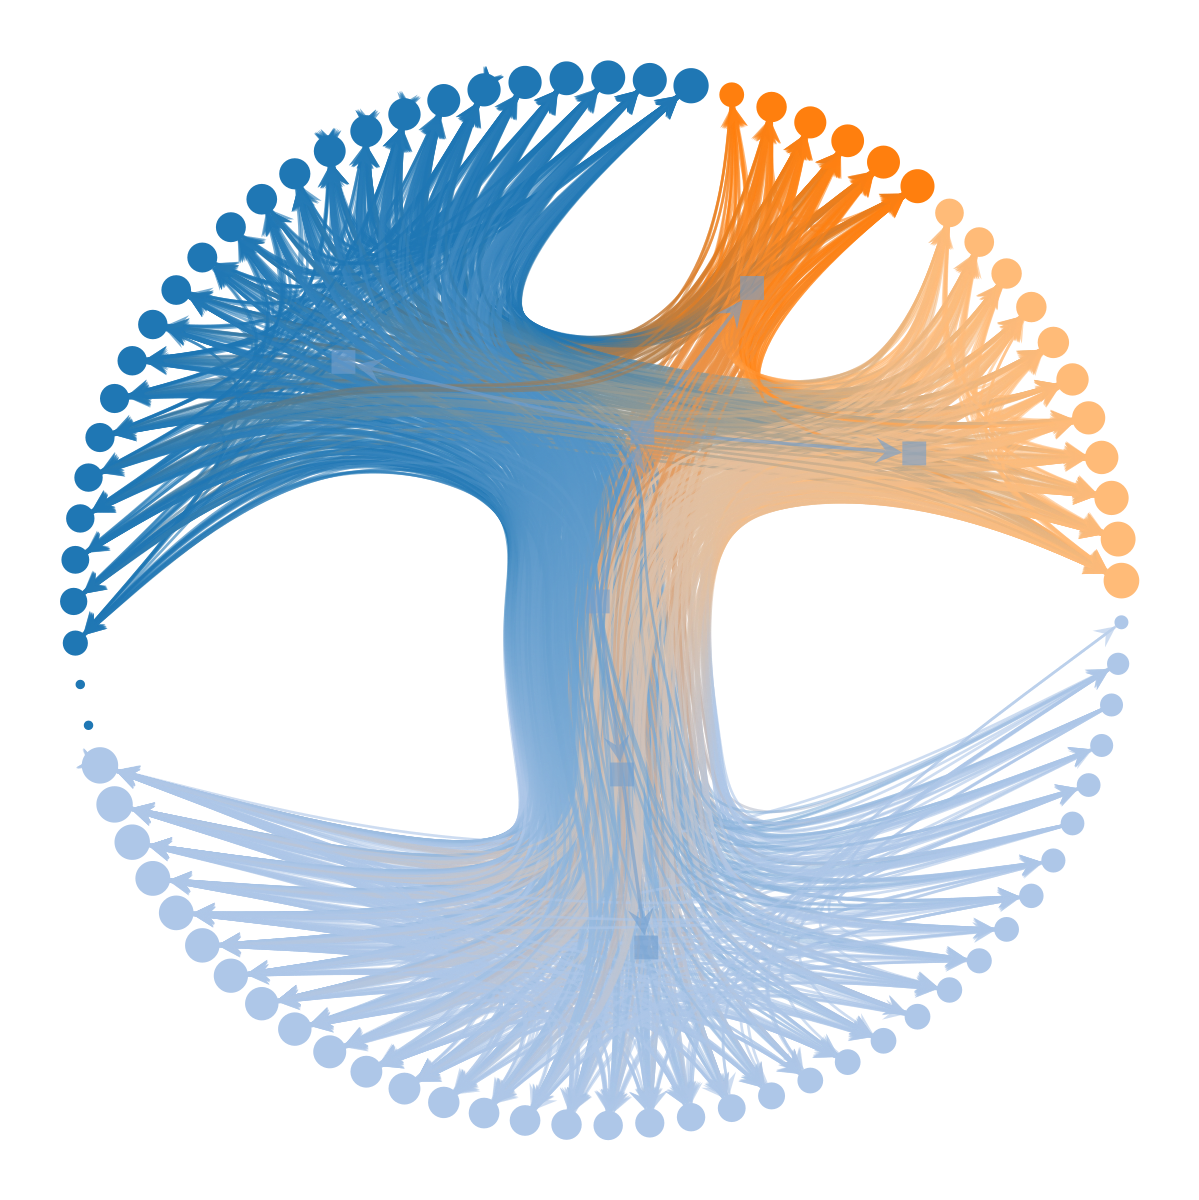

In [89]:
pos, colors, state, widths = SFDP_layout(big_graph)
big_pos, big_t, big_tpos = state.draw()

In [29]:
pos, colors, state, widths = SFDP_layout(graphs[0])

<NestedBlockState object, with base <BlockState object with 70 blocks (2 nonempty), degree-corrected, with 1 edge covariate, for graph <Graph object, directed, with 70 vertices and 161 edges, at 0x7fe37ad90f50>, at 0x7fe37b8679d0>, and 8 levels of sizes [(70, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7fe383d0dc80>


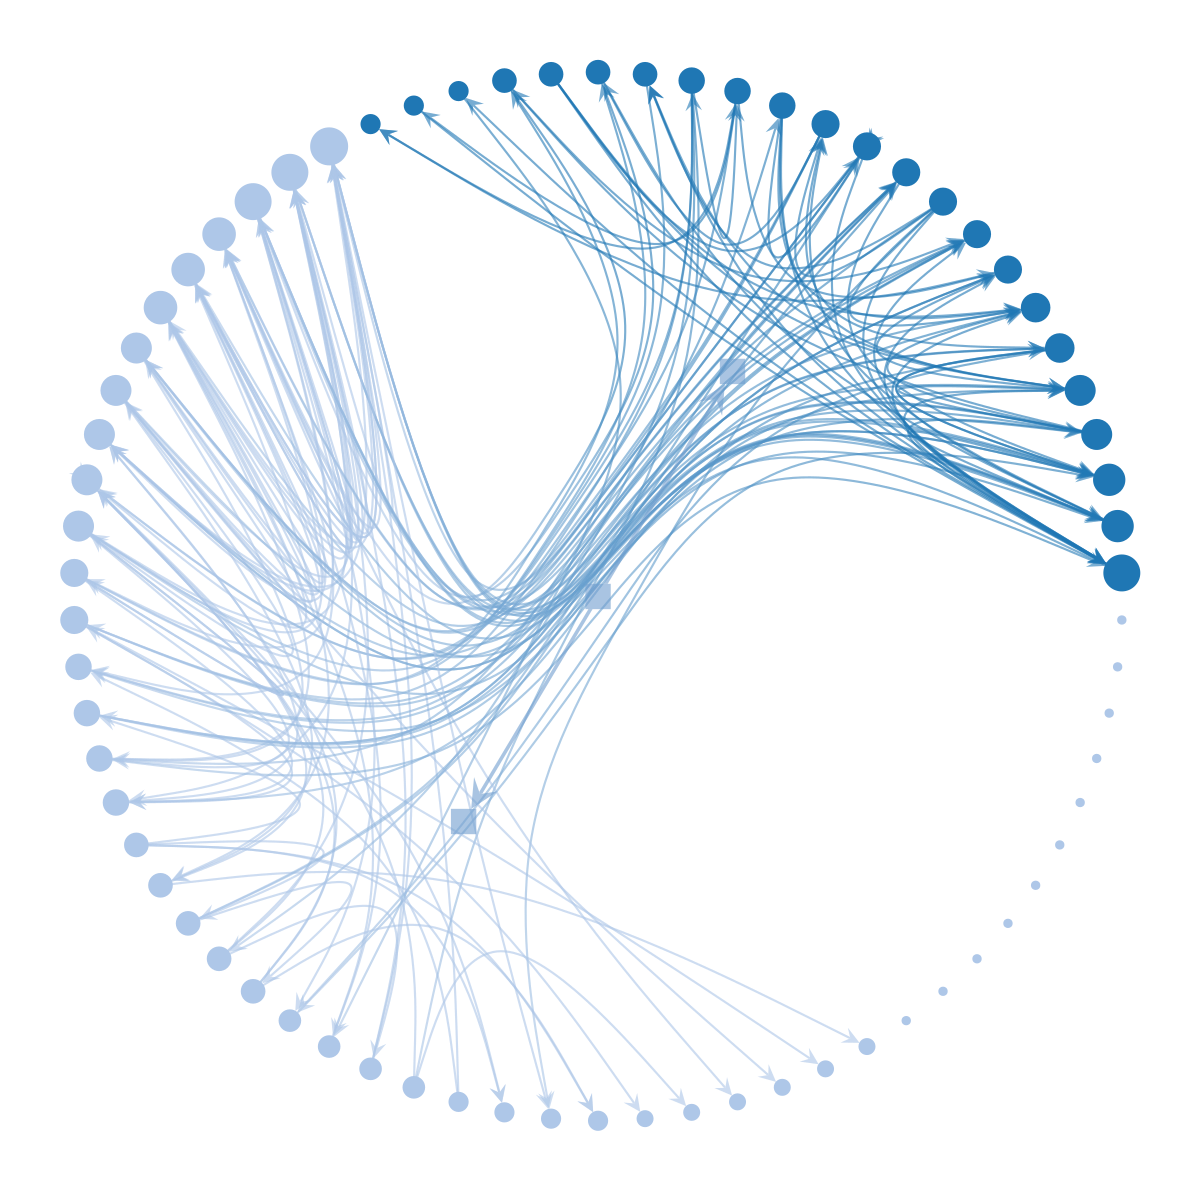

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe37ad90f50, at 0x7fe35dc24280>,
 <GraphView object, directed, with 73 vertices and 72 edges, edges filtered by <EdgePropertyMap object with value type 'bool', for Graph 0x7fe37ba85b30, at 0x7fe37ba05b00>, vertices filtered by <VertexPropertyMap object with value type 'bool', for Graph 0x7fe37ba85b30, at 0x7fe37ba05940>, at 0x7fe37ba85b30>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe37ba85b30, at 0x7fe37ba04670>)

In [31]:
state.draw()

In [30]:
state.draw(pos = pos_g,
        ecmap=(matplotlib.cm.seismic, .6),
        edge_color=ecolor,
        # eorder=eweight_static,
        # edge_pen_width=gt.prop_to_size(eweight,
        #                                   1, 4,
        #                                   power=1,
        #                                   log=False),
        edge_gradient=[]);

NameError: name 'pos_g' is not defined

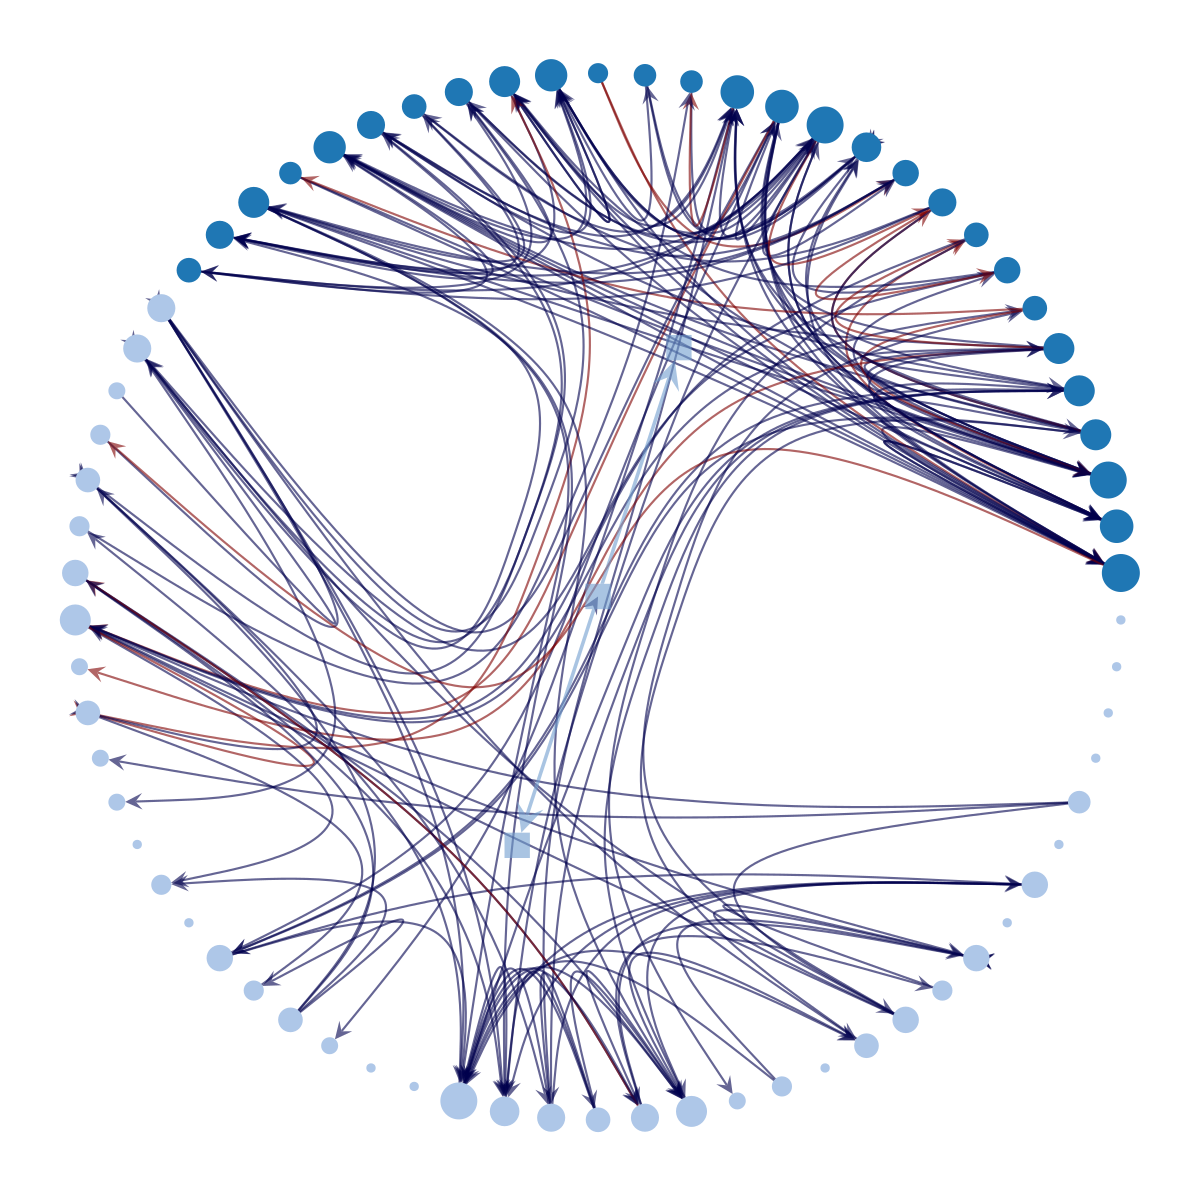

In [127]:

import graph_tool.all as gt
import matplotlib.cm
gt.seed_rng(1)

idx = 0
g = gt.Graph(directed=True, )

eweight = g.new_ep("double")
eweight_static = g.new_ep("double")

ecolor = g.new_ep("double")

vlist = {}
for node in graph.nodes:
    #add vertex with the same index as in networkx (example: '32848242')
    vlist[node] = g.add_vertex()
for edge in graphs[idx].edges:
    g.add_edge(vlist[edge[0]], vlist[edge[1]])
    eweight[g.edge(vlist[edge[0]], vlist[edge[1]])] = (granger_causalities[idx][edge[0], edge[1]])
    ecolor[g.edge(vlist[edge[0]], vlist[edge[1]])] = 0 if (granger_causalities[idx][edge[0], edge[1]] > 0) else 1


pos_g = g.new_vertex_property("vector<double>")
for v in g.vertices():
    pos_g[v] = big_pos[v]

state = gt.minimize_nested_blockmodel_dl(g)#, state_args=dict(recs=[eweight], rec_types=["real-normal"]))


# # ARGUMENTS FROM draw_hierarchy()
state.draw(pos = pos_g,
        ecmap=(matplotlib.cm.seismic, .6),
        edge_color=ecolor,
        # eorder=eweight_static,
        # edge_pen_width=gt.prop_to_size(eweight,
        #                                   1, 4,
        #                                   power=1,
        #                                   log=False),
        edge_gradient=[]);


In [120]:
state

<NestedBlockState object, with base <BlockState object with 70 blocks (2 nonempty), degree-corrected, with 1 edge covariate, for graph <Graph object, directed, with 70 vertices and 161 edges, at 0x7fee23937cf0>, at 0x7fee23984050>, and 8 levels of sizes [(70, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7fee23d04cd0>

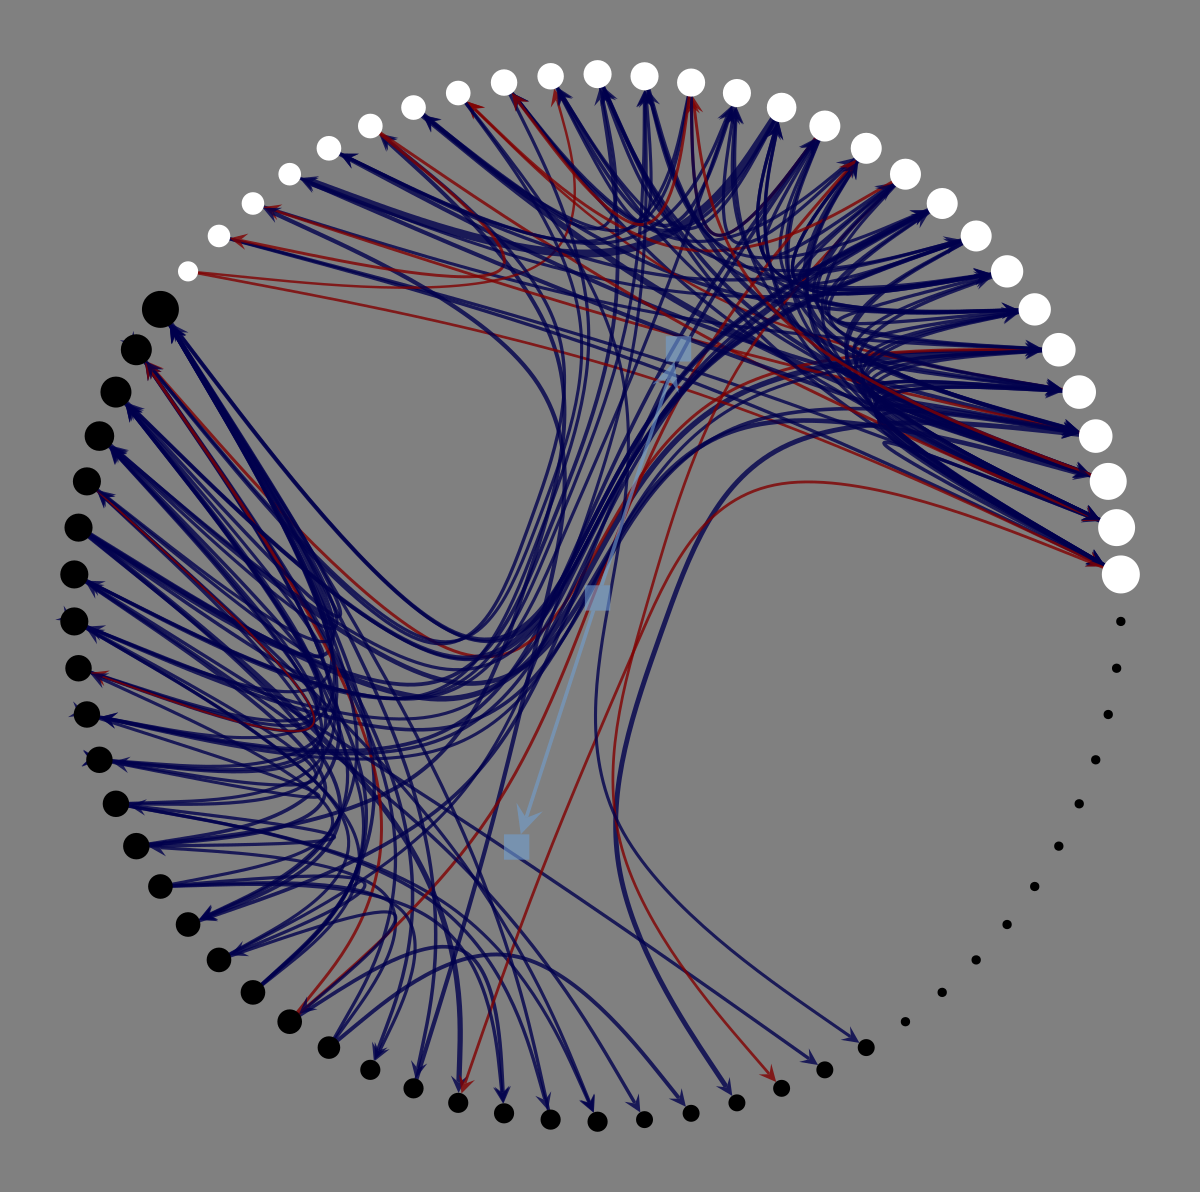

In [ ]:
gt.draw_hierarchy(state,# pos=big_pos,
                  ecmap=(matplotlib.cm.seismic, .8),
                  edge_color=ecolor,
                  edge_pen_width=gt.prop_to_size(eweight,
                                                  1, 4,
                                                  power=1,
                                                  log=False),
                    # remove hierarchy
                  hvprops=dict(alpha=1),
                  edge_gradient=[],
                  bg_color = 'grey');


In [72]:
from itertools import combinations

def is_balanced_triangle(edge_signs):
    product = edge_signs[0] * edge_signs[1] * edge_signs[2]
    return product > 0  # +1 (balanced) if positive product

def calculate_balance(graph):
    triangles = [nodes for nodes in combinations(graph.nodes, 3)
                 if graph.has_edge(nodes[0], nodes[1]) and
                    graph.has_edge(nodes[0], nodes[2]) and
                    graph.has_edge(nodes[1], nodes[2])]
    balanced_count = 0

    for u, v, w in triangles:
        edge_signs = [
            graph[u][v]['sign'],
            graph[u][w]['sign'],
            graph[v][w]['sign']
        ]
        if is_balanced_triangle(edge_signs):
            balanced_count += 1

    total_triangles = len(triangles)
    if total_triangles == 0:
        return 1.0, 0  # trivially balanced if no triangles

    return (balanced_count/total_triangles,total_triangles)

for graph in graphs:
    for u, v in graph.edges():
        # Assign a sign to each edge based on the causality value
        sign = 1 if granger_causalities[idx][u, v] > 0 else -1
        graph[u][v]['sign'] = sign

    balance, triangles = calculate_balance(graph)
    print(f"Balance ratio: {balance:.2f}, Total triangles: {triangles}")


Balance ratio: 0.83, Total triangles: 6
Balance ratio: 0.42, Total triangles: 26
Balance ratio: 0.36, Total triangles: 11
Balance ratio: 0.00, Total triangles: 69
